In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pylab as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([ # 流水线
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean and std 
    ])
datasetRootPath = '/Volumes/OTHERS/data/'
trainSet = torchvision.datasets.CIFAR10( # keras.datasets.cifar100 
        root=datasetRootPath, train=True, download=True, transform=transform)
testSet  = torchvision.datasets.CIFAR10(
        root=datasetRootPath, train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=16, shuffle=True, num_workers=2)
testLoader  = torch.utils.data.DataLoader(testSet,  batch_size=16, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


horse frog horse horse dog ship ship bird deer bird bird deer bird car ship bird


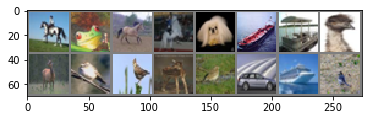

In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataIter = iter(trainLoader)
imgs, labels = dataIter.next()
imshow(torchvision.utils.make_grid(imgs))
print(' '.join(np.array(classes)[labels]))

In [4]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, (3, 3))
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.selu(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        return self.fc3(x)
    
net = MyNet()

In [5]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(20):
    running_loss = 0
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        output = net(inputs) # 正向传播
        loss = criterion(output, labels) # loss
        loss.backward() # 反向传播
        optimizer.step() # 更新模型参数
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.
        
print('ending!')

[1  2000] loss: 1.768
[2  2000] loss: 1.411
[3  2000] loss: 1.260
[4  2000] loss: 1.157
[5  2000] loss: 1.073
[6  2000] loss: 1.014
[7  2000] loss: 0.956
[8  2000] loss: 0.911
[9  2000] loss: 0.879
[10  2000] loss: 0.831
ending!


'GroundTruth: frog plane ship horse cat dog dog horse car bird bird deer car cat dog truck'

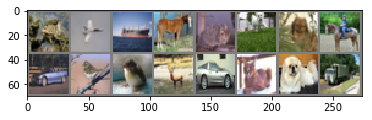

In [7]:
testIter = iter(testLoader)
imgs, labels = testIter.next()

imshow(torchvision.utils.make_grid(imgs))
'GroundTruth: ' + ' '.join(np.array(classes)[labels.numpy()])

In [8]:
output = net(imgs)
output

tensor([[ 2.6716,  0.3749, -0.3140,  0.5634, -0.1759, -0.1404,  1.7284,  0.7708,
         -5.9613,  2.5891],
        [ 4.2886, -5.4475,  1.6230,  0.9013,  2.5378,  0.5999, -2.3971, -2.0550,
          3.7447, -2.7755],
        [ 4.3456, -1.2096,  0.4955, -0.6177, -0.6659, -2.0121, -3.5971, -4.2485,
          8.8824, -1.1105],
        [-3.0674, -5.7906,  0.8362,  1.1916,  5.3838,  1.0986, -2.0778,  9.5868,
         -7.0453, -1.7742],
        [-1.6442, -2.7354, -0.3457,  4.1325,  0.0892,  1.9175, -0.1039, -0.7470,
          0.6909, -0.2314],
        [-1.8887, -1.9142,  3.0747,  0.2316,  2.2715, -0.7031, -3.0697,  5.6290,
         -4.2286, -1.6334],
        [-3.8457, -5.6213,  3.4038,  1.7143,  0.5041,  1.3795,  1.2994,  3.8164,
         -4.4463,  0.2973],
        [ 0.3492, -2.1815, -0.7356, -0.5214,  1.4599, -0.5153, -4.5096,  8.0925,
         -4.7572, -2.0187],
        [ 2.8060,  4.9333, -2.2666, -2.7272, -0.9497, -4.3975, -3.6601,  2.0144,
         -0.3253,  1.9132],
        [ 2.5171, -

In [9]:
_, predicted = torch.max(output, dim=1)
'prediction: ' + ' '.join(np.array(classes)[predicted.numpy()])

'prediction: plane plane ship horse cat horse horse horse car bird cat deer car dog dog truck'

In [10]:
correct = 0
total = 0
with torch.no_grad(): # stop gradient look
    for data in testLoader:
        imgs, labels = data
        output = net(imgs)
        _, predicted = torch.max(output.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('%.2f%%' % (correct / total * 100))

64.98%


In [13]:
class_correct = np.zeros(10)
class_total = np.zeros(10)
with torch.no_grad():
    for data in testLoader:
        imgs, labels = data
        output = net(imgs)
        _, predicted = torch.max(output, dim=1)
        c =  (predicted == labels).squeeze().numpy()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[labels] += 1
            
for i in range(10):
    print('[%5s]: %.2f%%' % (classes[i], 100 * class_correct[i] / class_total[i]))

[plane]: 8.19%
[  car]: 9.51%
[ bird]: 5.89%
[  cat]: 5.69%
[ deer]: 7.90%
[  dog]: 5.91%
[ frog]: 9.32%
[horse]: 9.47%
[ ship]: 10.02%
[truck]: 7.73%
